## Cell 1: 

In [2]:
import pandas as pd

# Load the file
df_check = pd.read_csv('final_bag_pass_count.csv')

print("--- Column Headers in your file ---")
print(df_check.columns.tolist())

--- Column Headers in your file ---
['Date', 'Bag_count', 'PassengerCount']


## Cell 2 

Cleaned 2023 data loaded successfully. Found 12 months.
Preparing the 12-month data...

--- Final 12-Month Time Series Data (BpP Ratio) ---
            Bag_count  PassengerCount  bags_per_passenger  month
Date                                                            
2023-01-01    67900.0         81593.0            0.832179      1
2023-02-01    57891.0         69703.0            0.830538      2
2023-03-01    57940.0         79261.0            0.731003      3
2023-04-01    81043.0        100062.0            0.809928      4
2023-05-01    74666.0        103823.0            0.719166      5
2023-06-01    59740.0         85250.0            0.700762      6
2023-07-01    83880.0        103089.0            0.813666      7
2023-08-01    69839.0         91358.0            0.764454      8
2023-09-01    57823.0        100793.0            0.573681      9
2023-10-01    63523.0         99432.0            0.638859     10
2023-11-01    62604.0         87745.0            0.713477     11
2023-12-01    5

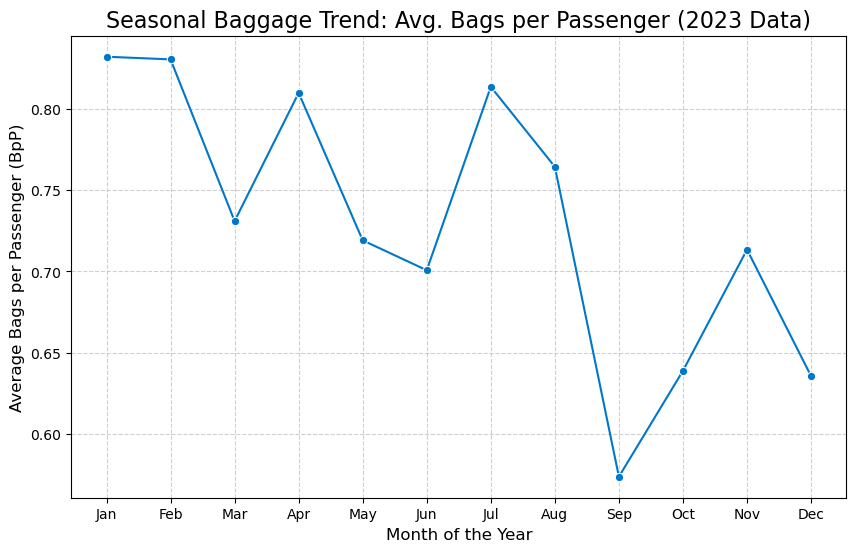

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- FIXED COLUMN NAMES ---
DATE_COLUMN_NAME = 'Date' 
BAG_COLUMN_NAME = 'Bag_count'
PASSENGER_COLUMN_NAME = 'PassengerCount'
# ---

# 1. Load your teammate's data (12 rows expected)
try:
    # NOTE: Since the data is small, we can manually create the DataFrame for quick testing
    # But we'll write the code to read the CSV for deployment.
    df_forecast = pd.read_csv('final_bag_pass_count.csv')
    print(f"Cleaned 2023 data loaded successfully. Found {len(df_forecast)} months.")
except FileNotFoundError:
    print("ERROR: File 'final_bag_pass_count.csv' not found. Check the file path.")
    raise

# --- 2. CLEAN AND PREPARE THE 12 ROWS ---
print("Preparing the 12-month data...")

# 2a. Convert to datetime using the *explicit* format: Month-Year
df_forecast['Date'] = pd.to_datetime(
    df_forecast[DATE_COLUMN_NAME], 
    format='%m-%y' # Explicitly tells pandas: "This is Month-Year"
)

# 2b. Calculate the Bags per Passenger (BpP) Ratio
df_forecast['bags_per_passenger'] = df_forecast[BAG_COLUMN_NAME] / df_forecast[PASSENGER_COLUMN_NAME]

# 2c. Set the Date as the index (best practice for time series)
df_forecast = df_forecast.set_index('Date')
df_forecast['month'] = df_forecast.index.month # Add month number for the plot

print("\n--- Final 12-Month Time Series Data (BpP Ratio) ---")
print(df_forecast)

# 3. Visualize the BpP Seasonality 
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_forecast, x='month', y='bags_per_passenger', marker='o', color='#0077c9')
plt.title('Seasonal Baggage Trend: Avg. Bags per Passenger (2023 Data)', fontsize=16)
plt.xlabel('Month of the Year', fontsize=12)
plt.ylabel('Average Bags per Passenger (BpP)', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Cell 3


--- Cell 2: Building Final Hybrid Forecast with SARIMA ---
BpP Ratio Factors (2023 baseline) Loaded.
Historical 10-year passenger data loaded from 'net_csvpassengers.csv'.
Training SARIMA model on 10 years of passenger data (this may take a minute)...
SARIMA model training complete.
Forecasting 2025-2026 passenger counts...
Using assumed Revenue per Bag: $40.0

--- Final 2026 Hybrid Revenue Forecast (SARIMA) ---


,Month,Predicted_Passengers,BpP_Ratio,Revenue_M
0,1,8.024375e+06,0.832179,267.108721
1,2,7.978515e+06,0.830538,265.058439
2,3,9.750088e+06,0.731003,285.093613
3,4,9.408253e+06,0.809928,304.800254
4,5,9.928572e+06,0.719166,285.611767
5,6,1.006445e+07,0.700762,282.111518
6,7,1.035867e+07,0.813666,337.139913
7,8,9.244384e+06,0.764454,282.676307
8,9,8.831575e+06,0.573681,202.660176
9,10,9.415307e+06,0.638859,240.602028



TOTAL ANNUAL REVENUE FORECAST (2026): $3,238.20 Million


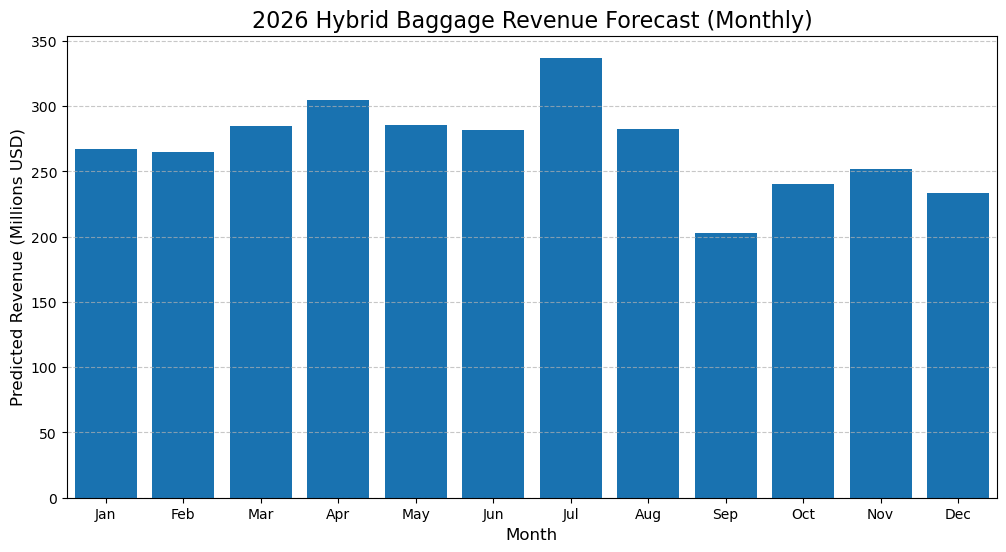

In [22]:
## 2. Final 2026 Hybrid Revenue Forecast (using SARIMA)

import pandas as pd
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from IPython.display import display

print("\n--- Cell 2: Building Final Hybrid Forecast with SARIMA ---")

# 1. Load the 2023 BpP Ratios we saved from Cell 1
try:
    df_bpp_ratios = pd.read_csv('bpp_seasonal_factors.csv')
    print("BpP Ratio Factors (2023 baseline) Loaded.")
except FileNotFoundError:
    print("ERROR: 'bpp_seasonal_factors.csv' not found. Please run Cell 1 first.")
    raise

# 2. Load and Prepare the Historical Passenger Data
try:
    df_history = pd.read_csv('net_csvpassengers.csv')
    print("Historical 10-year passenger data loaded from 'net_csvpassengers.csv'.")
except FileNotFoundError:
    print("ERROR: 'net_csvpassengers.csv' not found. Please make sure the file is in the same folder.")
    raise

# Create the full date column
df_history['Date'] = pd.to_datetime(df_history['Year'].astype(str) + '-' + df_history['Month'].astype(str) + '-01')
df_history = df_history.set_index('Date')
df_history = df_history.sort_index()

# --- THIS IS THE FIX ---
# We must explicitly set the frequency of the index to 'Month Start'
# This ensures the SARIMAX forecast object has a proper DatetimeIndex.
df_history = df_history.asfreq('MS')
# --- END OF FIX ---


# 3. --- Define and Train the SARIMA Model ---
# We will train on all data up to the end of 2024
df_train = df_history['TOTAL'].loc[:'2024-12-01']

# Define the SARIMA model
sarima_model = SARIMAX(
    df_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

print("Training SARIMA model on 10 years of passenger data (this may take a minute)...")
sarima_results = sarima_model.fit(disp=False)
print("SARIMA model training complete.")

# 4. --- Create the Final 2026 Forecast (Passengers) ---
# We need to forecast 24 steps into the future (all of 2025 and 2026)
print("Forecasting 2025-2026 passenger counts...")
forecast_object = sarima_results.get_forecast(steps=24)
forecast_24_months = forecast_object.predicted_mean

# Now that the index is a DatetimeIndex, this filter will work
forecast_2026_series = forecast_24_months[forecast_24_months.index.year == 2026]
df_forecast_2026 = forecast_2026_series.to_frame(name='Predicted_Passengers')

df_forecast_2026['Month'] = df_forecast_2026.index.month

# 5. --- Final Hybrid Revenue Calculation ---
REVENUE_PER_BAG = 40.00 # Example: $40 per bag
print(f"Using assumed Revenue per Bag: ${REVENUE_PER_BAG}")

# Merge the Passenger Forecast with the BpP Ratio
df_final_forecast = pd.merge(df_forecast_2026, df_bpp_ratios, on='Month', how='inner')

# Calculate the final predicted bag count
df_final_forecast['Predicted_Bags_2026'] = (
    df_final_forecast['Predicted_Passengers'] * df_final_forecast['BpP_Ratio']
)

# Calculate the final predicted revenue
df_final_forecast['Predicted_Revenue_2026'] = (
    df_final_forecast['Predicted_Bags_2026'] * REVENUE_PER_BAG
)

print("\n--- Final 2026 Hybrid Revenue Forecast (SARIMA) ---")
df_final_forecast['Revenue_M'] = df_final_forecast['Predicted_Revenue_2026'] / 1_000_000
display(df_final_forecast[['Month', 'Predicted_Passengers', 'BpP_Ratio', 'Revenue_M']])

total_revenue = df_final_forecast['Predicted_Revenue_2026'].sum()
print(f"\nTOTAL ANNUAL REVENUE FORECAST (2026): ${total_revenue / 1_000_000:,.2f} Million")

# 6. --- Visualize the Final Forecast ---
plt.figure(figsize=(12, 6))
sns.barplot(data=df_final_forecast, x='Month', y='Revenue_M', color='#0077c9')
plt.title('2026 Hybrid Baggage Revenue Forecast (Monthly)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Predicted Revenue (Millions USD)', fontsize=12)
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()